实验三：实现k-means聚类方法和混合高斯模型</br>
目标：实现一个k-means算法和混合高斯模型，并且用EM算法估计模型中的参数。</br>
要求：用高斯分布产生k个高斯分布的数据（不同均值和方差）（其中参数自己设定）。</br>
（1）用k-means聚类，测试效果；</br>
（2）用混合高斯模型和你实现的EM算法估计参数，看看每次迭代后似然值变化情况，考察EM算法是否可以获得正确的结果（与你设定的结果比较）。</br>
应用：可以UCI上找一个简单问题数据，用你实现的GMM进行聚类。

# 导入必要库

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import collections
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal

np.random.seed(1)
plt.style.use("seaborn-v0_8")

# 高斯分布数据生成


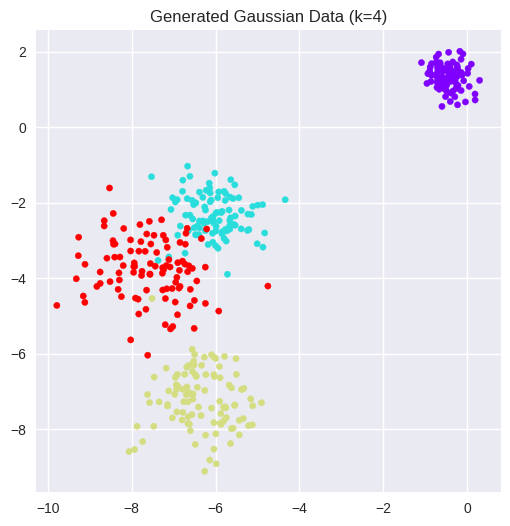

真实中心： [[-0.49786797  1.32194696]
 [-5.9986275  -2.37200913]
 [-6.35839397 -7.33790529]
 [-7.52975493 -3.70654255]]


In [80]:
class DataGenerator:
  def __init__(self, type_count=3, size=100, mu_differ=3.0):
    """
    type_count: 类别数 k
    size: 每类样本数
    mu_differ: 类均值之间的间隔
    """

    self.type_count = type_count
    self.size = size
    self.mu_differ = mu_differ

    # 随机生成均值与协方差矩阵
    self.mus = [np.random.uniform(-mu_differ, mu_differ, size=2) * (i + 1)
          for i in range(type_count)]
    self.covs = [np.eye(2) * (0.1 + 0.2 * i) for i in range(type_count)]

    # 生成数据
    self.data = np.vstack([
      np.random.multivariate_normal(self.mus[i], self.covs[i], size)
      for i in range(type_count)
    ])

    # 保存标签
    self.labels = np.hstack([[i] * size for i in range(type_count)])

  def plot(self):
    plt.figure(figsize=(6, 6))
    plt.scatter(self.data[:, 0], self.data[:, 1], c=self.labels, cmap='rainbow', s=20)
    plt.title(f"Generated Gaussian Data (k={self.type_count})")
    plt.show()

  def get_data(self):
    return self.data

  def get_centers(self):
    return np.array(self.mus)
generator = DataGenerator(type_count=4, size=100)
data = generator.get_data()
generator.plot()
print("真实中心：", generator.get_centers())


# Kmeans算法



In [81]:
class KMeans:
  def __init__(self, data, k, delta=1e-6):
    # 保存输入数据
    self.data = data
    self.k = k
    self.delta = delta
    self.data_rows, self.data_columns = data.shape
    # 初始化簇中心（距离最远）
    self.mu = self._init_center_not_random()
    # 保存每个样本所属的簇编号（初始为 -1）
    self.assignments = [-1] * self.data_rows

  @staticmethod
  def _euclidean_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

  def _init_center_not_random(self):
    """
    retrun：
      ndarray — 初始中心集合，形状为 (k, 特征数)
    """
    # 随机选择一个样本点作为第一个中心
    mu = [self.data[np.random.randint(0, self.data_rows)]]

    # 依次选取后续中心点
    for _ in range(1, self.k):

      # 计算每个样本点到当前所有中心点的距离和
      dist_sum = np.array([sum(self._euclidean_distance(x, m) for m in mu)
                                 for x in self.data])
      # 选取距离总和最大的样本点作为新中心
      mu.append(self.data[np.argmax(dist_sum)])
    return np.array(mu)

  def fit(self):
    """
    执行 K-Means 聚类的主过程
    步骤：
      1. 根据当前簇中心，将所有样本分配到最近的簇；
      2. 根据分配结果，重新计算每个簇的均值作为新中心；
      3. 若新旧中心的变化量低于阈值 delta，则停止迭代；
      4. 输出最终的簇中心和每个样本的聚类结果。

    返回：
      (mu, assignments)
        mu : ndarray
            聚类后簇中心坐标
        assignments : list[int]
            每个样本所属的簇编号
    """

    iteration = 0 # 记录迭代次数
    while True:
      # Step 1:样本分配
      c = collections.defaultdict(list)
      for i in range(self.data_rows):
        # 计算该样本与所有簇中心的距离，找出最小值
        dists = [self._euclidean_distance(self.data[i], self.mu[j]) for j in range(self.k)]
        cluster_id = np.argmin(dists)
        # 将该样本归入对应簇
        c[cluster_id].append(self.data[i])
        # 记录样本的簇编号
        self.assignments[i] = cluster_id

      # Step 2:更新簇中心
      new_mu = np.array([np.mean(c[i], axis=0) for i in range(self.k)])

      # Step 3:收敛条件
      loss = np.sum(self._euclidean_distance(self.mu[i], new_mu[i]) for i in range(self.k))

      if loss <= self.delta:
        break
      self.mu = new_mu
      iteration += 1

    print(f"K-Means 收敛，共迭代 {iteration} 次。")
    return self.mu, self.assignments


K-Means 收敛，共迭代 6 次。


/tmp/ipython-input-803194165.py:69: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  loss = np.sum(self._euclidean_distance(self.mu[i], new_mu[i]) for i in range(self.k))
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:

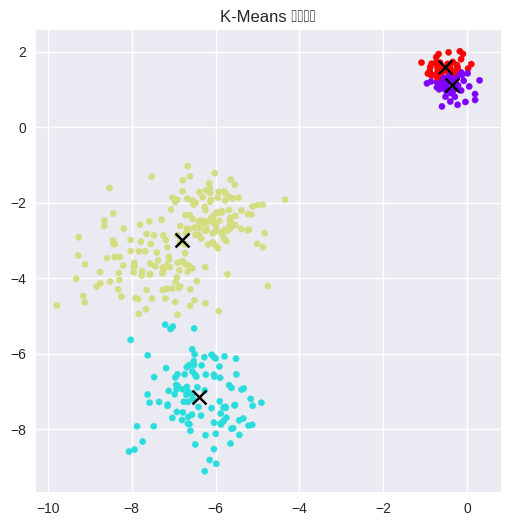

K-Means 聚类中心：
 [[-0.36132544  1.12796188]
 [-6.39360895 -7.15087729]
 [-6.79522383 -2.99487105]
 [-0.52355281  1.59137424]]


In [82]:
def test_kmeans(data, k):
  kmeans = KMeans(data, k)
  mu, assign = kmeans.fit()
  plt.figure(figsize=(6, 6))
  plt.scatter(data[:, 0], data[:, 1], c=assign, cmap='rainbow', s=20)
  plt.scatter(mu[:, 0], mu[:, 1], c='black', marker='x', s=100)
  plt.title("K-Means 聚类结果")
  plt.show()
  print("K-Means 聚类中心：\n", mu)

test_kmeans(data, 4)


# GMM算法

In [83]:
class GaussianMixtureModel:
  def __init__(self, data, k=3, delta=1e-6, max_iter=200):
    self.data = data
    self.k = k
    self.delta = delta
    self.max_iter = max_iter
    self.data_rows, self.data_columns = data.shape

    # 初始化混合系数 α_k，均分权重
    self.alpha = np.ones(k) / k

    # 初始化均值 mu_k，采用“最远距离”
    self.mu = self._init_center_not_random()

    # 初始化协方差 \Sigma_k，初始为0.5单位阵
    self.sigma = {i: np.eye(self.data_columns) * 0.5 for i in range(k)}

    # 保存上一次迭代参数，用于判断收敛
    self.last_alpha = self.alpha.copy()
    self.last_mu = self.mu.copy()
    self.last_sigma = self.sigma.copy()

    # 初始化责任度矩阵 γ 和似然值列表
    self.gamma = None
    self.likelihoods = []

  def _init_center_not_random(self):
    """
    retrun：
      ndarray — 初始中心集合，形状为 (k, 特征数)
    """
    # 随机选择一个样本点作为第一个中心
    mu = [self.data[np.random.randint(0, self.data_rows)]]

    # 依次选取后续中心点
    for _ in range(1, self.k):

      # 计算每个样本点到当前所有中心点的距离和
      dist_sum = np.array([sum(np.linalg.norm(x - m) for m in mu)
                                 for x in self.data])
      # 选取距离总和最大的样本点作为新中心
      mu.append(self.data[np.argmax(dist_sum)])
    return np.array(mu)


  def _likelihood(self):
    """
    计算每个样本在每个高斯分量下的概率密度（似然值矩阵）
    返回：
      L : ndarray, 形状 (样本数, k)
          L[i, j] = N(x_i | μ_j, Σ_j)
    """
    L = np.zeros((self.data_rows, self.k))
    for i in range(self.k):
      # scipy multivariate_normal 计算多维高斯密度
      L[:, i] = multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
    return L

  def _e_step(self):
    """
    E 步：计算每个样本属于各个高斯分量的后验概率 \gamma_ik。
    同时记录当前迭代的对数似然值 log-likelihood。
    """
    L = self._likelihood() * self.alpha         # 权重化的似然值
    sum_L = np.expand_dims(np.sum(L, axis=1), axis=1)  # 对样本维求和
    self.gamma = L / sum_L                # 归一化得到责任度 γ_ik
    self.likelihoods.append(np.sum(np.log(sum_L)))      # 记录总似然值

  def _m_step(self):
    """
    M 步：根据责任度 \gamma 更新模型参数。
    """
    for i in range(self.k):
      gamma_i = np.expand_dims(self.gamma[:, i], axis=1)
      total_gamma = gamma_i.sum() # 分量 k 的总权重（有效样本数）

      # 更新均值 μ_k
      self.mu[i] = (gamma_i * self.data).sum(axis=0) / total_gamma

      # 更新协方差 Σ_k
      diff = self.data - self.mu[i]
      self.sigma[i] = (gamma_i * diff).T @ diff / total_gamma

      # 更新混合系数 α_k
      self.alpha[i] = total_gamma / self.data_rows

  def _converged(self):
    """
    判断收敛
    """
    diff = np.linalg.norm(self.alpha - self.last_alpha) \
        + np.linalg.norm(self.mu - self.last_mu)
    self.last_alpha, self.last_mu = self.alpha.copy(), self.mu.copy()
    return diff < self.delta

  def fit(self):
    for i in range(self.max_iter):
      self._e_step()
      self._m_step()
      if self._converged():
        print(f"GMM 收敛于第 {i+1} 次迭代。")
        break
    return self.mu, self.alpha, self.likelihoods


<>:61: SyntaxWarning: invalid escape sequence '\g'
<>:71: SyntaxWarning: invalid escape sequence '\g'
<>:61: SyntaxWarning: invalid escape sequence '\g'
<>:71: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3461518619.py:61: SyntaxWarning: invalid escape sequence '\g'
  E 步：计算每个样本属于各个高斯分量的后验概率 \gamma_ik。
/tmp/ipython-input-3461518619.py:71: SyntaxWarning: invalid escape sequence '\g'
  M 步：根据责任度 \gamma 更新模型参数。


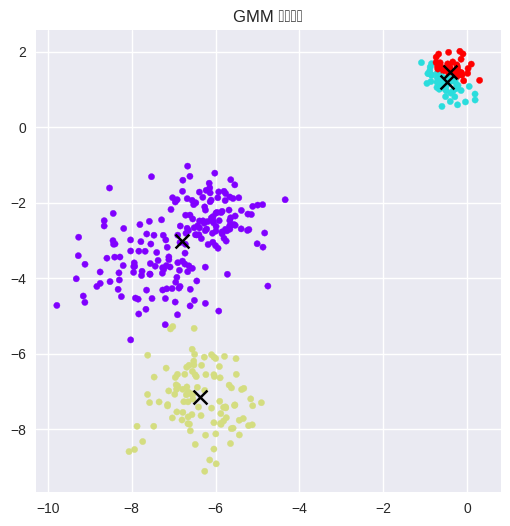

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20284 (\N{CJK UNIFIED IDEOGRAPH-4F3C}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28982 (\N{CJK UNIFIED IDEOGRAPH-7136}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) Liberatio

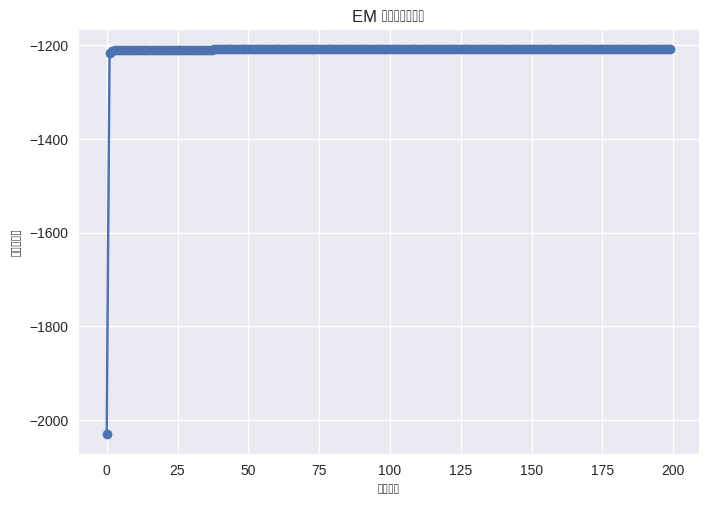

GMM 聚类中心：
 [[-6.80270756 -3.00977189]
 [-0.47025328  1.20185414]
 [-6.37590961 -7.1601665 ]
 [-0.39375429  1.46673179]]
GMM 混合系数：
 [0.48983775 0.12729317 0.26016225 0.12270683]


In [84]:
def test_gmm(data, k):
  gmm = GaussianMixtureModel(data, k)
  mu, alpha, likelihoods = gmm.fit()

  labels = np.argmax(gmm.gamma, axis=1)
  plt.figure(figsize=(6, 6))
  plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='rainbow', s=20)
  plt.scatter(mu[:, 0], mu[:, 1], c='black', marker='x', s=100)
  plt.title("GMM 聚类结果")
  plt.show()

  plt.figure()
  plt.plot(likelihoods, marker='o')
  plt.title("EM 算法似然值变化")
  plt.xlabel("迭代次数")
  plt.ylabel("对数似然值")
  plt.show()

  print("GMM 聚类中心：\n", mu)
  print("GMM 混合系数：\n", alpha)

test_gmm(data, 4)


# 使用Iris数据集

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) Liberatio

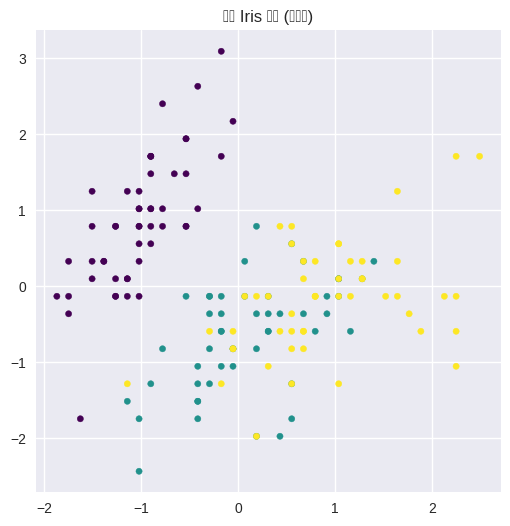

In [85]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

def load_iris_data():
  iris = load_iris()
  X = iris.data[:, :2]   # 只取前两维方便可视化
  y = iris.target
  X = StandardScaler().fit_transform(X)  # 标准化处理

  plt.figure(figsize=(6, 6))
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=20)
  plt.title("原始 Iris 数据 (前两维)")
  plt.show()
  return X, y
iris_data, iris_labels = load_iris_data()


/tmp/ipython-input-803194165.py:69: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  loss = np.sum(self._euclidean_distance(self.mu[i], new_mu[i]) for i in range(self.k))


K-Means 收敛，共迭代 6 次。


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) Liberatio

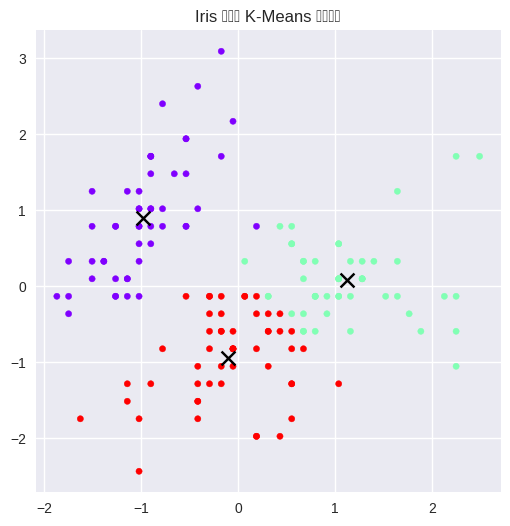

K-Means 聚类中心：
 [[-0.97822861  0.90390597]
 [ 1.12888066  0.08382999]
 [-0.10143926 -0.94652188]]
真实标签 vs 聚类标签（前20个样本）：
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [86]:
def iris_kmeans_experiment(data, true_labels, k=3):
  kmeans = KMeans(data, k)
  mu, assignments = kmeans.fit()

  plt.figure(figsize=(6, 6))
  plt.scatter(data[:, 0], data[:, 1], c=assignments, cmap='rainbow', s=20)
  plt.scatter(mu[:, 0], mu[:, 1], c='black', marker='x', s=100)
  plt.title("Iris 数据的 K-Means 聚类结果")
  plt.show()

  print("K-Means 聚类中心：\n", mu)
  print("真实标签 vs 聚类标签（前20个样本）：")
  print(np.vstack((true_labels[:20], assignments[:20])))

iris_kmeans_experiment(iris_data, iris_labels)


GMM 聚类准确率: 72.67%


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) Liberatio

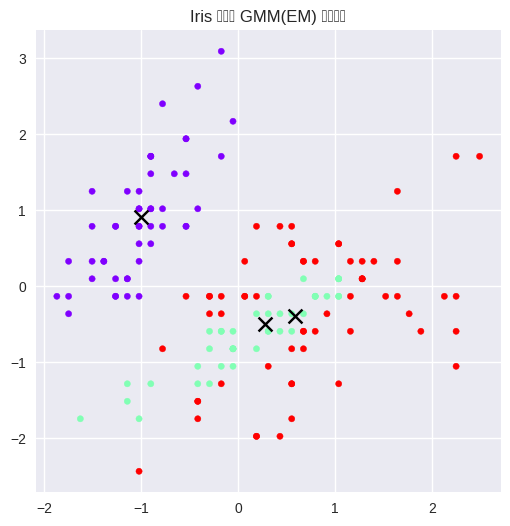

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20284 (\N{CJK UNIFIED IDEOGRAPH-4F3C}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28982 (\N{CJK UNIFIED IDEOGRAPH-7136}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31639 (\N{CJK UNIFIED IDEOGRAPH-7B97}) missing from font(s) Liberatio

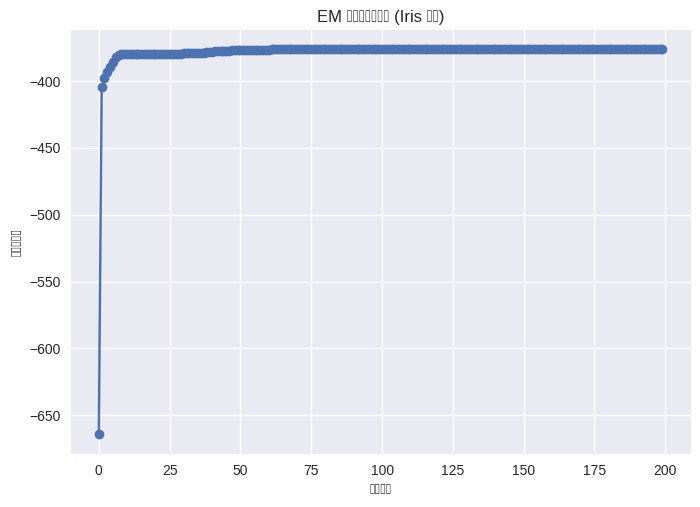

GMM 聚类中心：
 [[ 0.59067091 -0.39009877]
 [ 0.27986111 -0.50234824]
 [-1.00296475  0.9150134 ]]
混合系数：
 [0.42386607 0.25527757 0.32085636]
真实标签 vs 聚类标签（前100个样本）：
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 2 2 2 2 1 2 1 2 2 2 2 2 1 2 1 2 1 2 1 2 1
  2 1 1 1 2 1 1 1 2 2 1 1 2 2 1 2 2 1 1 1 1 1 1 2 2 1 1 1]]


In [87]:
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment

def iris_gmm_experiment(data, true_labels, k=3):
  gmm = GaussianMixtureModel(data, k)
  mu, alpha, likelihoods = gmm.fit()
  labels = np.argmax(gmm.gamma, axis=1)

  # 构建混淆矩阵（簇标签 vs 真标签）
  from sklearn.metrics import confusion_matrix
  cm = confusion_matrix(true_labels, labels)

  # 使用 Hungarian 算法（线性分配法）寻找最佳标签匹配
  row_ind, col_ind = linear_sum_assignment(-cm)
  optimal_mapping = {col: row for row, col in zip(row_ind, col_ind)}

  # 重新映射聚类标签
  mapped_labels = np.array([optimal_mapping[l] for l in labels])

  # 计算准确率
  acc = accuracy_score(true_labels, mapped_labels)
  print(f"GMM 聚类准确率: {acc * 100:.2f}%")

  plt.figure(figsize=(6, 6))
  plt.scatter(data[:, 0], data[:, 1], c=mapped_labels, cmap='rainbow', s=20)
  plt.scatter(mu[:, 0], mu[:, 1], c='black', marker='x', s=100)
  plt.title("Iris 数据的 GMM(EM) 聚类结果")
  plt.show()

  plt.figure()
  plt.plot(likelihoods, marker='o')
  plt.title("EM 算法似然值变化 (Iris 数据)")
  plt.xlabel("迭代次数")
  plt.ylabel("对数似然值")
  plt.show()

  print("GMM 聚类中心：\n", mu)
  print("混合系数：\n", alpha)
  print("真实标签 vs 聚类标签（前100个样本）：")
  print(np.vstack((true_labels[:100], mapped_labels[:100])))

# 运行实验
iris_gmm_experiment(iris_data, iris_labels)
